# Calculate power spectrum of along-slope velocity transformed into ASC coordinate system 

This scripts calculates power spectrum of daily along-slope velocity data that were transformed into an ASC coordinate system. The transformation is done in `Calc_ASCcoord_transform_ocean.ipynb`.

We use the ASC regimes as defined in `xyz.ipynb` to highlight different regions.

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client

# Optional modules
import cmocean as cm
import matplotlib.gridspec as gridspec

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores

In [2]:
client = Client() # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37201,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://10.6.121.40:35901,Total threads: 4
Dashboard: /proxy/40871/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:40111,


### Load in pre-calculated velocity data

In [3]:
file_path = '/g/data/x77/wgh581/Post_Process/'
file_name = 'transects_binned_daily_full_dropna.nc'

ds = xr.open_dataarray(file_path + file_name)

Barotropic velocity

In [4]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

In [5]:
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1) # , start_time=start_time, end_time=end_time.
st_edges_array = st_edges_ocean.expand_dims({'lon_shelf':ds.lon_shelf, 'depth_bin':ds.depth_bin}, axis=[1,2])

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ds.depth_bin, other=ds.depth_bin)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))
thickness = thickness

# We only need values down to the deepest depth_bin
st_ocean_slice = slice(0, 2000)
thickness = thickness.sel(st_ocean = st_ocean_slice)

In [ ]:
#ds = ds.load()

In [20]:
ds_barotropic = (ds * thickness).sum('st_ocean') / thickness.sum('st_ocean')

Bottom velocity

In [ ]:
# Array that has the depth levels
depth_array_1 = ds[:,0,:,:] * 0 + ds.st_ocean

# Get max depth of data (skipping nans)
max_depth_1   = depth_array_1.max(dim='st_ocean', skipna=True) 

# Select the bottom using max_depth: bottom is where the depth level is larger/equal the max depth
ds_bottom = ds.where(depth_array_1.st_ocean >= max_depth_1)
ds_bottom = ds_bottom.sum(dim='st_ocean')

Surface velocity

In [9]:
ds_surface = ds[:,:,0,:]

Surface 200 m average

In [10]:
ds_surface_200m = ds.sel(st_ocean=slice(0, 200))
thickness_200m  = thickness.sel(st_ocean=slice(0, 200))
ds_surface_200m = (ds_surface_200m * thickness_200m).sum('st_ocean') / thickness_200m.sum('st_ocean')

Set values out of range to nan

In [21]:
ds_barotropic = ds_barotropic.where(ds_barotropic != 0)
ds_barotropic = ds_barotropic.where(ds_barotropic <= 1)
ds_barotropic = ds_barotropic.where(ds_barotropic >= -1)

# ds_bottom = ds_bottom.where(ds_bottom != 0)
# ds_bottom = ds_bottom.where(ds_bottom <= 1)
# ds_bottom = ds_bottom.where(ds_bottom >= -1)

# ds_surface = ds_surface.where(ds_surface != 0)
# ds_surface = ds_surface.where(ds_surface <= 1)
# ds_surface = ds_surface.where(ds_surface >= -1)

# ds_surface_200m = ds_surface_200m.where(ds_surface_200m != 0)
# ds_surface_200m = ds_surface_200m.where(ds_surface_200m <= 1)
# ds_surface_200m = ds_surface_200m.where(ds_surface_200m >= -1)

### More infos used in various plots

First, remove lon/lat values from 630-m isobath that got removed as some transects had bumps.

In [22]:
in_file  = '/g/data/x77/wgh581/Post_Process/' + 'Antarctic_slope_transects_630m_2000m.npz'
in_data  = np.load(in_file)
lon_630m = in_data['lon_630m']
lat_630m = in_data['lat_630m']

In [23]:
index_nan = []
lon_shelf_nan = ds.lon_shelf.values
for ii in range(len(lon_630m)):
    if (lon_630m[ii] - lon_shelf_nan[ii]) != 0:
        lon_shelf_nan = np.insert(lon_shelf_nan, ii, lon_630m[ii])
        index_nan.append(ii)
index_nan = index_nan[::-1]

In [24]:
lon_630m_dropna = lon_630m.tolist()
lat_630m_dropna = lat_630m.tolist()
for ii in range(len(index_nan)):
    del lon_630m_dropna[index_nan[ii]]
    del lat_630m_dropna[index_nan[ii]]

Distance along the 1-km isobath

In [25]:
def gcdist(lat1, lat2, lon1, lon2):

    # Radius of the Earth in km
    r = 6371
    # Difference between points (lon/lat)
    dlon = lon2-lon1
    dlat = lat2-lat1
    # Calculate distance in km
    gcdist = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([lat1,lat2]))))**2))

    return gcdist

In [26]:
distance_along_contour = np.zeros((len(ds.lon_shelf)))
for ii in range(len(ds.lon_shelf)-1):
    lat1 = lat_630m_dropna[ii]
    lat2 = lat_630m_dropna[ii+1]
    lon1 = lon_630m_dropna[ii]
    lon2 = lon_630m_dropna[ii+1]
    distance_along_contour[ii+1] = gcdist(lat1, lat2, lon1, lon2)
distance_along_contour_cumsum = distance_along_contour.cumsum()

ASC regimes

In [27]:
# Load ASC classification (calculated in Calc_ASC_classification.ipynb)
file_path   = '/g/data/x77/wgh581/Post_Process/'
file_name   = 'ASC_regimes_01deg_jra55v13_ryf9091_plt_approach_smoothed_btm200m_50.npz'
ASC_regimes = np.load(file_path + file_name)
ASC_regimes = ASC_regimes['ASC_regimes_annual']

In [28]:
# Load lon/lat on 1km isobath, u-grid
file_name = 'Antarctic_slope_contour_1km_velocities_plt_approach.npz'
data = np.load(file_path + file_name)
#data.files
lon_along_contour = data['lon_along_contour']
lat_along_contour = data['lat_along_contour']

In [29]:
# Indeces with ASC regime information
var = np.diff(ASC_regimes)
index_tmp = [0]
ASC_tmp   = []
lon_test  = []
lat_test  = []
for ii in range(len(var)):
    if var[ii] != 0:
        lon_tmp = lon_along_contour[ii]
        lat_tmp = lat_along_contour[ii]
        index_tmp.append( np.argmin((lon_630m_dropna - lon_tmp)**2 + (lat_630m_dropna - lat_tmp)**2) )
        ASC_tmp.append(ASC_regimes[ii-1])
        lon_test.append(lon_tmp)
        lat_test.append(lat_tmp)
ASC_tmp.append(0)
index_tmp.append(len(ds.lon_shelf.values))

In [30]:
index_tmp[7] = 1960
index_tmp[8] = 1960

In [31]:
# Variable with regime info (one of: 0, 1, 2)
ASC_regimes_binned =  np.zeros(len(ds.lon_shelf)) * np.nan
for ii in range(len(ASC_tmp)):
    if ASC_tmp[ii] == 0:
        # Surface-intensified ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 0
    elif ASC_tmp[ii] == 1:
        # Bottom-intensified ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 1
    elif ASC_tmp[ii] == 2:
        # Reversed ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 2
ASC_regimes_binned_2d = np.vstack((ASC_regimes_binned, ASC_regimes_binned))

---

#### Power spectrum

In [32]:
def get_spectrum(data):
    sampling_rate = 1
    fourier_transform = np.fft.rfft(data)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))
    
    return frequency, power_spectrum

In [33]:
result = np.repeat(ASC_regimes_binned[np.newaxis,...], 183, axis=0).transpose()

Barotropic velocity

In [34]:
frequency = np.zeros((len(ds.lon_shelf), 183))
power_spectrum_barotropic = np.zeros((len(ds.lon_shelf), 183))

for ii in range(len(ds.lon_shelf)):
    frequency[ii,:], power_spectrum_barotropic[ii,:] = get_spectrum(ds_barotropic.mean('depth_bin')[ii])

In [38]:
# Save ds_barotropic and power_spectrum_barotropic
#ds_barotropic.to_netcdf('/g/data/x77/wgh581/Post_Process/ASC_Coordinate_Transformation/ds_barotropic.nc')

In [40]:
#np.savez('/g/data/x77/wgh581/Post_Process/ASC_Coordinate_Transformation/ds_barotropic_spectrum.npz', power_spectrum_barotropic=power_spectrum_barotropic, frequency_barotropic=frequency)

In [35]:
# Average over regimes
spectrum_bt_0 = np.where(result==0, power_spectrum_barotropic, np.nan)
spectrum_bt_std_0 = np.nanstd(spectrum_bt_0, axis=0)
spectrum_bt_0 = np.nanmean(spectrum_bt_0, axis=0)

spectrum_bt_1 = np.where(result==1, power_spectrum_barotropic, np.nan)
spectrum_bt_std_1 = np.nanstd(spectrum_bt_1, axis=0)
spectrum_bt_1 = np.nanmean(spectrum_bt_1, axis=0)

spectrum_bt_2 = np.where(result==2, power_spectrum_barotropic, np.nan)
spectrum_bt_std_2 = np.nanstd(spectrum_bt_2, axis=0)
spectrum_bt_2 = np.nanmean(spectrum_bt_2, axis=0)

In [36]:
# Repeat in log space
sp_bt_0 = np.log10(np.where(result==0, power_spectrum_barotropic, np.nan))
sp_bt_std_0 = np.nanstd(sp_bt_0, axis=0)
sp_bt_avg_0 = np.nanmean(sp_bt_0, axis=0)

sp_bt_1 = np.log10(np.where(result==1, power_spectrum_barotropic, np.nan))
sp_bt_std_1 = np.nanstd(sp_bt_1, axis=0)
sp_bt_avg_1 = np.nanmean(sp_bt_1, axis=0)

sp_bt_2 = np.log10(np.where(result==2, power_spectrum_barotropic, np.nan))
sp_bt_std_2 = np.nanstd(sp_bt_2, axis=0)
sp_bt_avg_2 = np.nanmean(sp_bt_2, axis=0)

Surface velocity (upper 200 m)

In [25]:
frequency = np.zeros((len(ds.lon_shelf), 183))
power_spectrum_surface_200m = np.zeros((len(ds.lon_shelf), 183))

for ii in range(len(ds.lon_shelf)):
    frequency[ii,:], power_spectrum_surface_200m[ii,:] = get_spectrum(ds_surface_200m.mean('depth_bin')[ii])

In [26]:
# Average over regimes
spectrum_sfc_0 = np.where(result==0, power_spectrum_surface_200m, np.nan)
spectrum_sfc_0 = np.nanmean(spectrum_sfc_0, axis=0)

spectrum_sfc_1 = np.where(result==1, power_spectrum_surface_200m, np.nan)
spectrum_sfc_1 = np.nanmean(spectrum_sfc_1, axis=0)

spectrum_sfc_2 = np.where(result==2, power_spectrum_surface_200m, np.nan)
spectrum_sfc_2 = np.nanmean(spectrum_sfc_2, axis=0)

Bottom velocity

In [27]:
frequency = np.zeros((len(ds.lon_shelf), 183))
power_spectrum_bottom = np.zeros((len(ds.lon_shelf), 183))

for ii in range(len(ds.lon_shelf)):
    frequency[ii,:], power_spectrum_bottom[ii,:] = get_spectrum(ds_bottom.mean('depth_bin')[ii])

In [28]:
# Average over regimes
spectrum_btm_0 = np.where(result==0, power_spectrum_bottom, np.nan)
spectrum_btm_0 = np.nanmean(spectrum_btm_0, axis=0)

spectrum_btm_1 = np.where(result==1, power_spectrum_bottom, np.nan)
spectrum_btm_1 = np.nanmean(spectrum_btm_1, axis=0)

spectrum_btm_2 = np.where(result==2, power_spectrum_bottom, np.nan)
spectrum_btm_2 = np.nanmean(spectrum_btm_2, axis=0)

### Plotting infos

In [41]:
ft_size  = 22
fig_path = '/g/data/x77/wgh581/Figures/Figures_Binned/'

# Axes
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Saving parameters
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

In [79]:
np.argmax(sp_bt_avg_2[3:])

2

In [75]:
frequency[ii,7]

0.019230769230769232

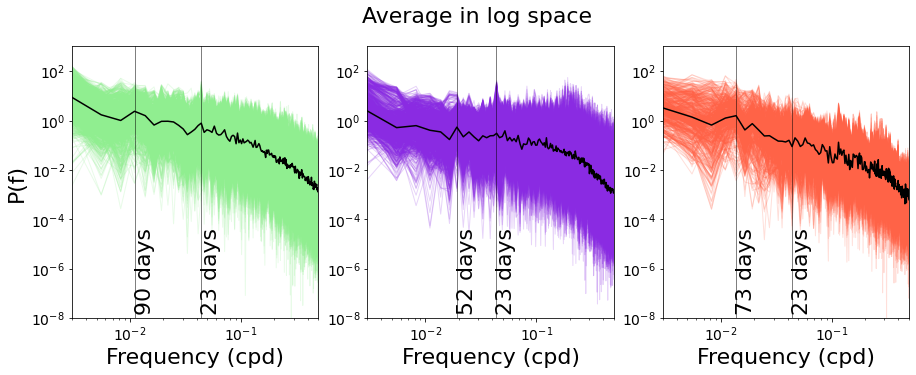

In [89]:
fig = plt.figure(figsize=(15,5))
plt.suptitle('Average in log space', fontsize=ft_size, y=0.99)

ax = plt.subplot(131)
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 0:
        plt.loglog(frequency[ii,1:], power_spectrum_barotropic[ii,1:], color='lightgreen', linewidth=1, alpha=0.2)
plt.loglog(frequency[0,1:], 10**sp_bt_avg_0[1:], color='k')
plt.ylabel('P(f)', fontsize=ft_size)
plt.xlim(3e-3, 5e-1)
plt.ylim(1e-8, 1e3)
plt.xlabel('Frequency (cpd)', fontsize=ft_size);  # cpd; cycles per day
plt.axvline(1/23, color='k', linewidth='0.5')
plt.text(1/23, 2e-8, '23 days', rotation=90, fontsize=ft_size)
plt.axvline(1/90, color='k', linewidth='0.5')
plt.text(1/90, 2e-8, '90 days', rotation=90, fontsize=ft_size)

plt.subplot(132)
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 1:
        plt.loglog(frequency[ii,1:], power_spectrum_barotropic[ii,1:], color='blueviolet', linewidth=1, alpha=0.2)
plt.loglog(frequency[0,1:], 10**sp_bt_avg_1[1:], color='k')
plt.xlim(3e-3, 5e-1)
plt.ylim(1e-8, 1e3)
plt.xlabel('Frequency (cpd)', fontsize=ft_size);  # cpd; cycles per day
plt.axvline(1/23, color='k', linewidth='0.5')
plt.text(1/23, 2e-8, '23 days', rotation=90, fontsize=ft_size)
plt.axvline(frequency[ii,7], color='k', linewidth='0.5')
plt.text(frequency[ii,7], 2e-8, '%i days'%(int(np.round(1/frequency[ii,7]))), rotation=90, fontsize=ft_size)

plt.subplot(133)
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 2:
        plt.loglog(frequency[ii,1:], power_spectrum_barotropic[ii,1:], color='tomato', linewidth=1, alpha=0.2)
plt.loglog(frequency[0,1:], 10**sp_bt_avg_2[1:], color='k')
plt.xlim(3e-3, 5e-1)
plt.ylim(1e-8, 1e3)
plt.xlabel('Frequency (cpd)', fontsize=ft_size);  # cpd; cycles per day
plt.axvline(1/23, color='k', linewidth='0.5')
plt.text(1/23, 2e-8, '23 days', rotation=90, fontsize=ft_size)
plt.axvline(frequency[ii,5], color='k', linewidth='0.5')
plt.text(frequency[ii,5], 2e-8, '%i days'%(int(np.round(1/frequency[ii,5]))), rotation=90, fontsize=ft_size);

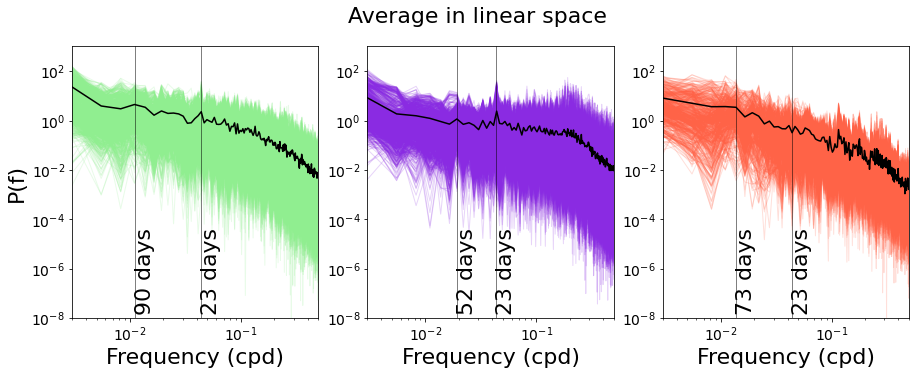

In [88]:
fig = plt.figure(figsize=(15,5))
plt.suptitle('Average in linear space', fontsize=ft_size, y=0.99)

ax = plt.subplot(131)
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 0:
        plt.loglog(frequency[ii,1:], power_spectrum_barotropic[ii,1:], color='lightgreen', linewidth=1, alpha=0.2)
plt.loglog(frequency[0,1:], spectrum_bt_0[1:], color='k')
plt.ylabel('P(f)', fontsize=ft_size)
plt.xlim(3e-3, 5e-1)
plt.ylim(1e-8, 1e3)
plt.xlabel('Frequency (cpd)', fontsize=ft_size);  # cpd; cycles per day
plt.axvline(1/23, color='k', linewidth='0.5')
plt.text(1/23, 2e-8, '23 days', rotation=90, fontsize=ft_size)
plt.axvline(1/90, color='k', linewidth='0.5')
plt.text(1/90, 2e-8, '90 days', rotation=90, fontsize=ft_size)

plt.subplot(132)
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 1:
        plt.loglog(frequency[ii,1:], power_spectrum_barotropic[ii,1:], color='blueviolet', linewidth=1, alpha=0.2)
plt.loglog(frequency[0,1:], spectrum_bt_1[1:], color='k')
plt.xlim(3e-3, 5e-1)
plt.ylim(1e-8, 1e3)
plt.xlabel('Frequency (cpd)', fontsize=ft_size);  # cpd; cycles per day
plt.axvline(1/23, color='k', linewidth='0.5')
plt.text(1/23, 2e-8, '23 days', rotation=90, fontsize=ft_size)
plt.axvline(frequency[ii,7], color='k', linewidth='0.5')
plt.text(frequency[ii,7], 2e-8, '%i days'%(int(np.round(1/frequency[ii,7]))), rotation=90, fontsize=ft_size)

plt.subplot(133)
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 2:
        plt.loglog(frequency[ii,1:], power_spectrum_barotropic[ii,1:], color='tomato', linewidth=1, alpha=0.2)
plt.loglog(frequency[0,1:], spectrum_bt_2[1:], color='k')
plt.xlim(3e-3, 5e-1)
plt.ylim(1e-8, 1e3)
plt.xlabel('Frequency (cpd)', fontsize=ft_size);  # cpd; cycles per day
plt.axvline(1/23, color='k', linewidth='0.5')
plt.text(1/23, 2e-8, '23 days', rotation=90, fontsize=ft_size)
plt.axvline(frequency[ii,5], color='k', linewidth='0.5')
plt.text(frequency[ii,5], 2e-8, '%i days'%(int(np.round(1/frequency[ii,5]))), rotation=90, fontsize=ft_size);

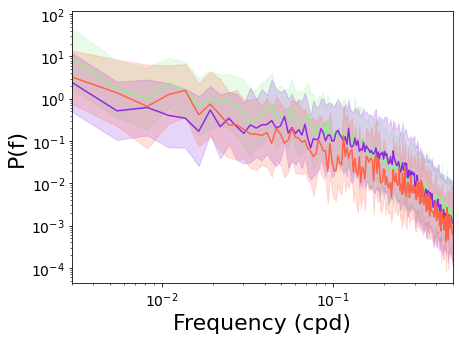

In [85]:
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
plt.loglog(frequency[0,1:], 10**sp_bt_avg_0[1:], color='lightgreen')
plt.fill_between(frequency[0,1:], 10**(sp_bt_avg_0-sp_bt_std_0)[1:], 10**(sp_bt_avg_0+sp_bt_std_0)[1:], color='lightgreen', alpha=0.2)

plt.loglog(frequency[0,1:], 10**sp_bt_avg_1[1:], color='blueviolet')
plt.fill_between(frequency[0,1:], 10**(sp_bt_avg_1-sp_bt_std_1)[1:], 10**(sp_bt_avg_1+sp_bt_std_1)[1:], color='blueviolet', alpha=0.2)

plt.loglog(frequency[0,1:], 10**sp_bt_avg_2[1:], color='tomato')
plt.fill_between(frequency[0,1:], 10**(sp_bt_avg_2-sp_bt_std_2)[1:], 10**(sp_bt_avg_2+sp_bt_std_2)[1:], color='tomato', alpha=0.2)

plt.xlim(3e-3, 5e-1)
plt.ylabel('P(f)', fontsize=ft_size)
plt.xlabel('Frequency (cpd)', fontsize=ft_size);  # cpd; cycles per day


In [ ]:
fig = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.loglog(spectrum_bt_std_2)
plt.loglog(spectrum_bt_2)

plt.subplot(132)
plt.loglog(10**sp_bt_std_2)
plt.loglog(10**sp_bt_avg_2)
plt.loglog(10**(sp_bt_avg_2-sp_bt_std_2))
plt.loglog(10**(sp_bt_avg_2+sp_bt_std_2))

plt.subplot(133)
plt.loglog(spectrum_bt_std_0, label='linear')
plt.loglog(10**sp_bt_std_0, label='log')
plt.legend()

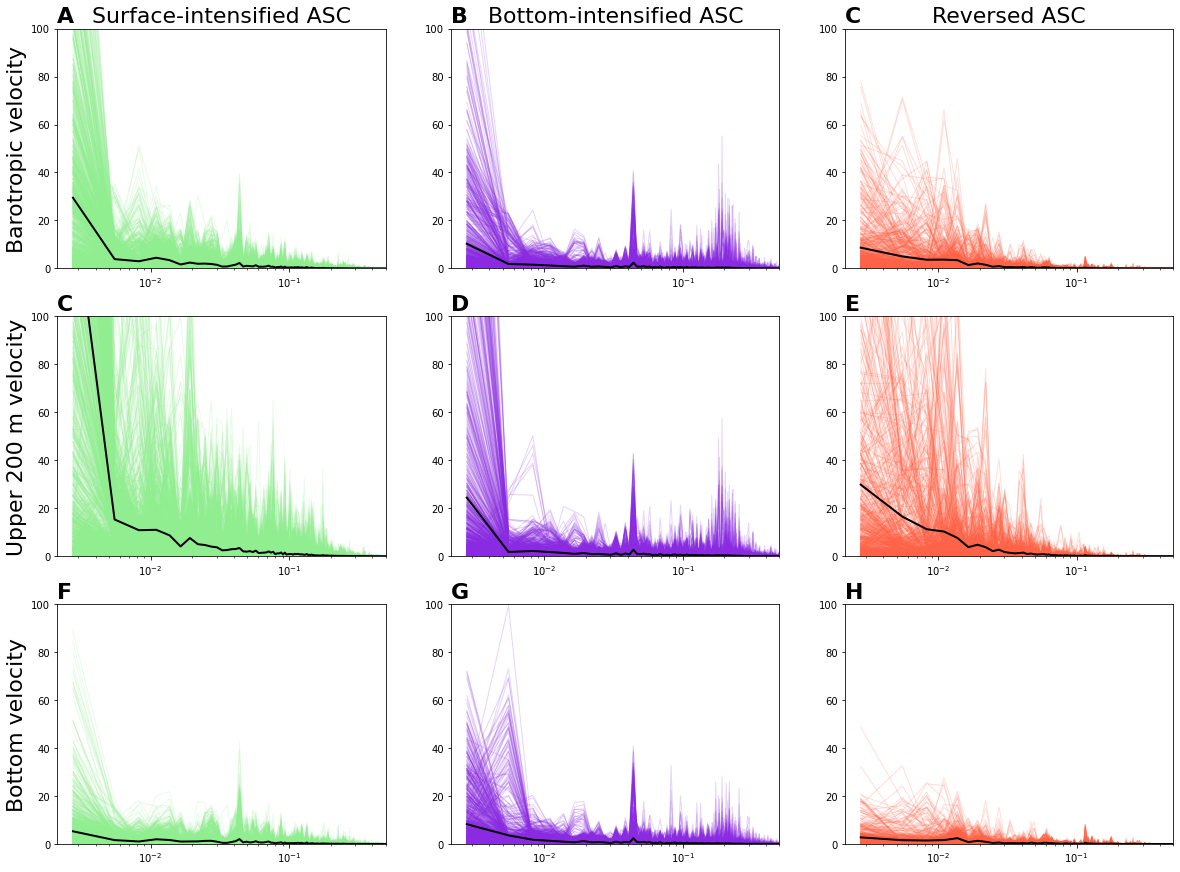

In [54]:
fig = plt.figure(figsize=(20,15))


# Barotropic velocity
plt.subplot(331)
plt.title('A', fontweight='bold', loc='left', fontsize=ft_size)
plt.title('Surface-intensified ASC', fontsize=ft_size)
plt.ylabel('Barotropic velocity', fontsize=ft_size)
clr = 'lightgreen'
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 0:
        plt.semilogx(frequency[ii,1:], power_spectrum_barotropic[ii,1:], color=clr, linewidth=1, alpha=0.2)
plt.plot(frequency[0,1:], spectrum_bt_0[1:], color='k', linewidth=2)
plt.ylim(0, 100)
plt.xlim(0, 0.5)

plt.subplot(332)
plt.title('B', fontweight='bold', loc='left', fontsize=ft_size)
plt.title('Bottom-intensified ASC', fontsize=ft_size)
clr = 'blueviolet'
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 1:
        plt.semilogx(frequency[ii,1:], power_spectrum_barotropic[ii,1:], color=clr, linewidth=1, alpha=0.2)
plt.plot(frequency[0,1:], spectrum_bt_1[1:], color='k', linewidth=2)
plt.ylim(0, 100)
plt.xlim(0, 0.5)

plt.subplot(333)
plt.title('C', fontweight='bold', loc='left', fontsize=ft_size)
plt.title('Reversed ASC', fontsize=ft_size)
clr = 'tomato'
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 2:
        plt.semilogx(frequency[ii,1:], power_spectrum_barotropic[ii,1:], color=clr, linewidth=1, alpha=0.2)
plt.plot(frequency[0,1:], spectrum_bt_2[1:], color='k', linewidth=2)
plt.ylim(0, 100)
plt.xlim(0, 0.5)


# Surface velocity
plt.subplot(334)
plt.title('C', fontweight='bold', loc='left', fontsize=ft_size)
plt.ylabel('Upper 200 m velocity', fontsize=ft_size)
clr = 'lightgreen'
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 0:
        plt.semilogx(frequency[ii,1:], power_spectrum_surface_200m[ii,1:], color=clr, linewidth=1, alpha=0.2)
plt.plot(frequency[0,1:], spectrum_sfc_0[1:], color='k', linewidth=2)
plt.ylim(0, 100)
plt.xlim(0, 0.5)

plt.subplot(335)
plt.title('D', fontweight='bold', loc='left', fontsize=ft_size)
clr = 'blueviolet'
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 1:
        plt.semilogx(frequency[ii,1:], power_spectrum_surface_200m[ii,1:], color=clr, linewidth=1, alpha=0.2)
plt.plot(frequency[0,1:], spectrum_sfc_1[1:], color='k', linewidth=2)
plt.ylim(0, 100)
plt.xlim(0, 0.5)

plt.subplot(336)
plt.title('E', fontweight='bold', loc='left', fontsize=ft_size)
clr = 'tomato'
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 2:
        plt.semilogx(frequency[ii,1:], power_spectrum_surface_200m[ii,1:], color=clr, linewidth=1, alpha=0.2)
plt.plot(frequency[0,1:], spectrum_sfc_2[1:], color='k', linewidth=2)
plt.ylim(0, 100)
plt.xlim(0, 0.5)


# Bottom velocity
plt.subplot(337)
plt.title('F', fontweight='bold', loc='left', fontsize=ft_size)
plt.ylabel('Bottom velocity', fontsize=ft_size)
clr = 'lightgreen'
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 0:
        plt.semilogx(frequency[ii,1:], power_spectrum_bottom[ii,1:], color=clr, linewidth=1, alpha=0.2)
plt.plot(frequency[0,1:], spectrum_btm_0[1:], color='k', linewidth=2)
plt.ylim(0, 100)
plt.xlim(0, 0.5)

plt.subplot(338)
plt.title('G', fontweight='bold', loc='left', fontsize=ft_size)
clr = 'blueviolet'
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 1:
        plt.semilogx(frequency[ii,1:], power_spectrum_bottom[ii,1:], color=clr, linewidth=1, alpha=0.2)
plt.plot(frequency[0,1:], spectrum_btm_1[1:], color='k', linewidth=2)
plt.ylim(0, 100)
plt.xlim(0, 0.5)

plt.subplot(339)
plt.title('H', fontweight='bold', loc='left', fontsize=ft_size)
clr = 'tomato'
for ii in range(len(ASC_regimes_binned)):
    if ASC_regimes_binned[ii] == 2:
        plt.semilogx(frequency[ii,1:], power_spectrum_bottom[ii,1:], color=clr, linewidth=1, alpha=0.2)
plt.plot(frequency[0,1:], spectrum_btm_2[1:], color='k', linewidth=2)
plt.ylim(0, 100)
plt.xlim(0, 0.5)



# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_binned_power_spectrum_subplots.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

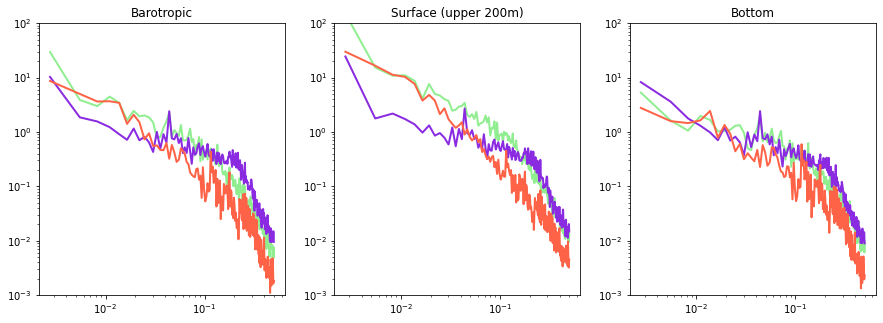

In [53]:
fig = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Barotropic')
plt.plot(frequency[0,1:], spectrum_bt_0[1:], color='lightgreen', linewidth=2)
plt.plot(frequency[0,1:], spectrum_bt_1[1:], color='blueviolet', linewidth=2)
plt.loglog(frequency[0,1:], spectrum_bt_2[1:], color='tomato', linewidth=2)
plt.ylim(1e-3,1e2)

plt.subplot(132)
plt.title('Surface (upper 200m)')
plt.plot(frequency[0,1:], spectrum_sfc_0[1:], color='lightgreen', linewidth=2)
plt.plot(frequency[0,1:], spectrum_sfc_1[1:], color='blueviolet', linewidth=2)
plt.loglog(frequency[0,1:], spectrum_sfc_2[1:], color='tomato', linewidth=2)
plt.ylim(1e-3,1e2)

plt.subplot(133)
plt.title('Bottom')
plt.plot(frequency[0,1:], spectrum_btm_0[1:], color='lightgreen', linewidth=2)
plt.plot(frequency[0,1:], spectrum_btm_1[1:], color='blueviolet', linewidth=2)
plt.loglog(frequency[0,1:], spectrum_btm_2[1:], color='tomato', linewidth=2)
plt.ylim(1e-3,1e2)

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_binned_power_spectrum_regime_averages.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

In [89]:
n = 5
int(np.round(1/frequency[0,n+spectrum_bt_2[n:].argmax()]))

73

In [123]:
np.round(1/frequency[0,1],4)

364.0

In [51]:
print(np.round(1/(8*1e-3),4), 'days')
print(np.round(1/(1*1e-2),4), 'days')
print(np.round(1/(2*1e-2),4), 'days')
print(np.round(1/(4*1e-2),4), 'days')
print(np.round(1/(5*1e-2),4), 'days')
print(np.round(1/(2*1e-1),4), 'days')


125.0 days
100.0 days
50.0 days
25.0 days
20.0 days
5.0 days


(0.0, 10.0)

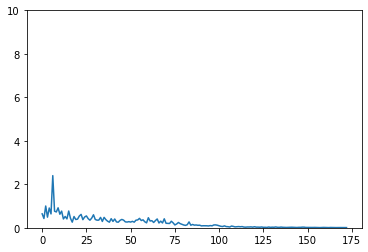

In [38]:
plt.plot(spectrum_bt_1[10:])
plt.ylim(0, 10)

In [41]:
1/frequency[0, 10+np.argmax(spectrum_bt_1[10:])]

22.75